In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
from matplotlib import pyplot as plt
import numpy as np
import sys
import os
from sklearn.cluster import DBSCAN
from math import floor


In [3]:
import os
import sys

# Get the current directory
current_dir = os.path.dirname(os.path.abspath('__file__'))
print('current_dir:', current_dir)

# Get the parent directory
parent_dir = os.path.dirname(os.path.dirname(current_dir))
print('parent_dir:', parent_dir)

# Get the segment_clustereuse directory
segment_clustereuse_dir = os.path.join(parent_dir, 'segment_clustereuse')
print('segment_clustereuse_dir:', segment_clustereuse_dir)

# Add the parent directory to sys.path
sys.path.append(segment_clustereuse_dir)
sys.path.append(parent_dir)

current_dir: /Volumes/CrucialX/hlybokyi-potik/segment_clustereuse/test
parent_dir: /Volumes/CrucialX/hlybokyi-potik
segment_clustereuse_dir: /Volumes/CrucialX/hlybokyi-potik/segment_clustereuse


In [4]:
from segment_clustereuse.dsa import TDFParams
from segment_clustereuse.spectral_clustereuse import get_spectral_cluster, plot_segments_with_labels, get_spectral_embedding
from segment_clustereuse.sim_model import get_similarity_matrix, theta, explain_similarity
from path_prefix import PATH_PREFIX

In [33]:
# Load the segments from the pickle file
with open(PATH_PREFIX + '/data/segments/flight_segments_1716508800.pickle', 'rb') as f:
    segments_file = pickle.load(f)
    print('Segments file loaded')
    
seg_from_lat = segments_file['seg_from_lat']
seg_from_lon = segments_file['seg_from_lon']
seg_to_lat = segments_file['seg_to_lat']
seg_to_lon = segments_file['seg_to_lon']

# Convert deque to np.array
seg_from_lat = np.array(seg_from_lat)
seg_from_lon = np.array(seg_from_lon)
seg_to_lat = np.array(seg_to_lat)
seg_to_lon = np.array(seg_to_lon)

Segments file loaded


In [34]:
print(f'There are {len(seg_from_lat)} segments in the dataset')

There are 2654 segments in the dataset


In [35]:
N_SEGS = 777
MIN_LENGTH = 0.5

# Prune segments that are too short
dx = seg_to_lon - seg_from_lon
dy = seg_to_lat - seg_from_lat

# Compute the norm (length) of each segment
segment_norms = np.sqrt(dx**2 + dy**2)

# Filter out segments that are too short
indices_len_pruned = segment_norms > MIN_LENGTH
seg_from_lat = seg_from_lat[indices_len_pruned]
seg_from_lon = seg_from_lon[indices_len_pruned]
seg_to_lat = seg_to_lat[indices_len_pruned]
seg_to_lon = seg_to_lon[indices_len_pruned]

print(f'{len(seg_from_lat)} segments are left after length pruning')

if len(seg_from_lat) > N_SEGS:
    np.random.seed(69251)
    indices = np.random.choice(len(seg_from_lat), N_SEGS, replace=False).tolist()
    seg_from_lat = seg_from_lat[indices]
    seg_from_lon = seg_from_lon[indices]
    seg_to_lat = seg_to_lat[indices]
    seg_to_lon = seg_to_lon[indices]

print(f'{N_SEGS} segments are sampled')



1403 segments are left after length pruning
777 segments are sampled


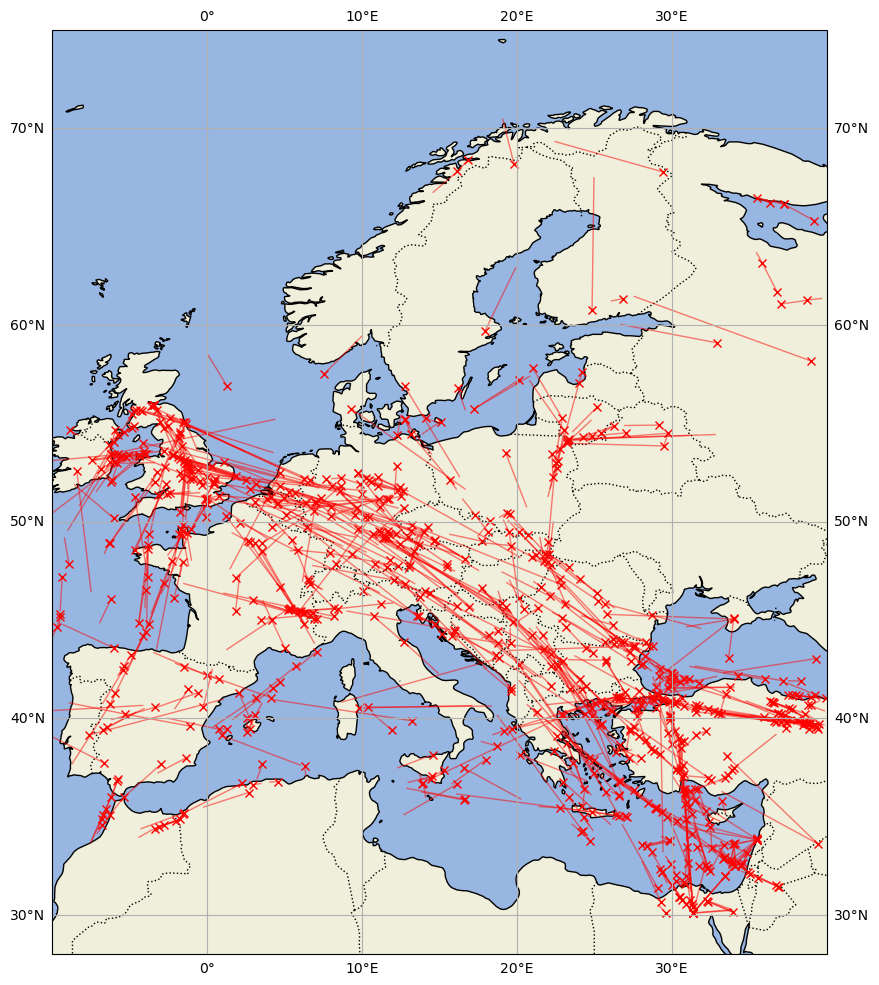

In [37]:
plot_segments_with_labels(seg_from_lat, seg_from_lon, seg_to_lat, seg_to_lon, cluster_labels=None, filter=None, show_labels=False)

In [38]:
the = {
        'psi_bar': TDFParams(tau=0.01, alpha=12., x0=50.),  # psi_bar = 1 - psi, where psi is the cosine similarity
        'wO': TDFParams(tau=0.01, alpha=24., x0=1.),  # weight of overlap
        'wH': TDFParams(tau=0.01, alpha=24., x0=1.),   # weight of horizontal separation
        'O': TDFParams(tau=0.9, alpha=5., x0=30.),   # overlap
        'H': TDFParams(tau=1e-3, alpha=5., x0=70.)   # horizontal separation
}

In [39]:
explain_similarity(seg_from_lat, seg_from_lon, seg_to_lat, seg_to_lon, the, 113, 93)

Segment 1: [0.85976907 0.30494137] to [0.87311213 0.3188037 ]
Segment 2: [ 0.78290249 -0.12086941] to [ 0.80401637 -0.10808572]
psi_bar:  38.695045569304604
O_term:  9.415552385263448e-09
H_term:  5.243594917453042
tdf(psi_bar): 38.695045569304604
tdf(wO): 0.598922620644224
tdf(O): 1.5720816113333174e-08
O: 5.173895503469728
tdf(wH): 0.598922620644224
H: 0.4167730111776781
tdf(H): 8.755045704924004
Similarity between segment 113 and segment 93 is 14.6462134987244


In [40]:
explain_similarity(seg_from_lat, seg_from_lon, seg_to_lat, seg_to_lon, the, 42, 129)

Segment 1: [0.872155   0.38981416] to [0.83699452 0.38433839]
Segment 2: [0.76476092 0.22237185] to [0.78838463 0.18792064]
Returns 0 because the flow directions are perpendicular or opposite!
Flow direction similarity: -1.0


100%|██████████| 777/777 [00:39<00:00, 19.76it/s] 


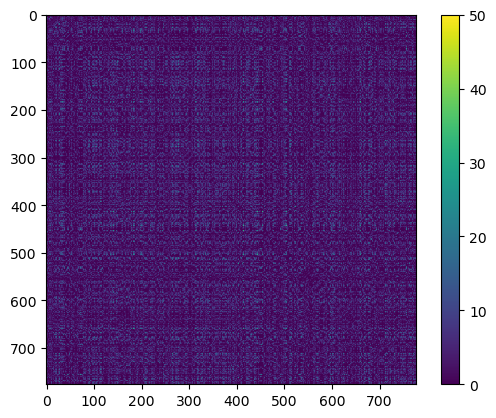

In [41]:
similarity_matrix = get_similarity_matrix(seg_from_lat, seg_from_lon, seg_to_lat, seg_to_lon, the)
plt.imshow(similarity_matrix)
plt.colorbar()
plt.show()

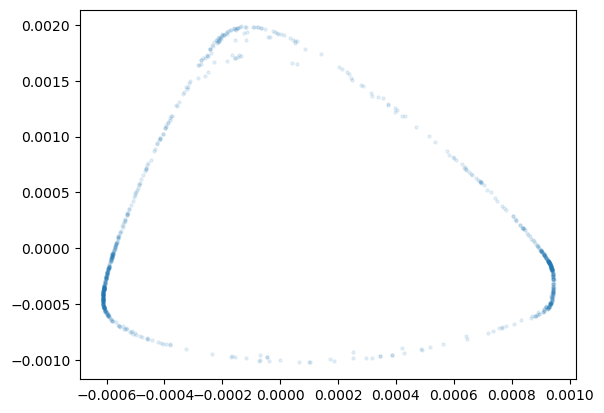

In [58]:
embeddings = get_spectral_embedding(similarity_matrix)
plt.scatter(embeddings[:, 0], embeddings[:, 1], s=5, alpha=0.1)
# Add a text label to the point with the index of the segment
# for i, txt in enumerate(range(len(seg_from_lat))):
#     plt.text(embeddings[i, 0], embeddings[i, 1], str(txt), fontsize=8, ha='center', va='bottom')
plt.show()
# plt.hist(similarity_matrix[(similarity_matrix > 0.01) & (similarity_matrix < 1)], bins=100)
# plt.show()

Smallest cluster label: -1
Largest cluster label: 2
Number of points with cluster label -1 (noise): 182 / 777


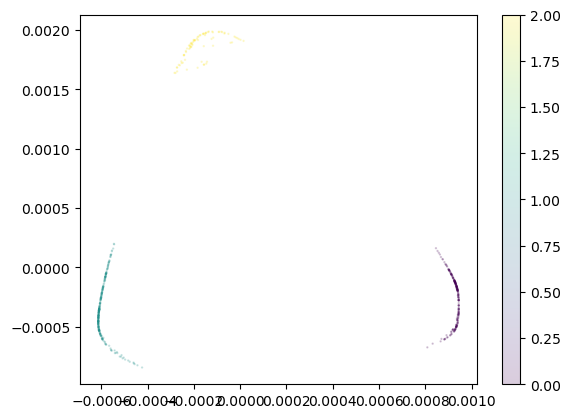

In [54]:
# Perform clustering with DBSCAN over the embeddings
dbscan = DBSCAN(eps=1e-4, min_samples=20)
cluster_labels = dbscan.fit_predict(embeddings)
print(f'Smallest cluster label: {cluster_labels.min()}')
print(f'Largest cluster label: {cluster_labels.max()}')
print(f'Number of points with cluster label -1 (noise): {np.sum(cluster_labels == -1)} / {len(cluster_labels)}')
embeddings_no_noise = embeddings[cluster_labels != -1]
cluster_labels_no_noise = cluster_labels[cluster_labels != -1]
plt.scatter(embeddings_no_noise[:, 0], embeddings_no_noise[:, 1], c=cluster_labels_no_noise, cmap='viridis', s=0.5, alpha=0.2)
plt.colorbar()
plt.show()

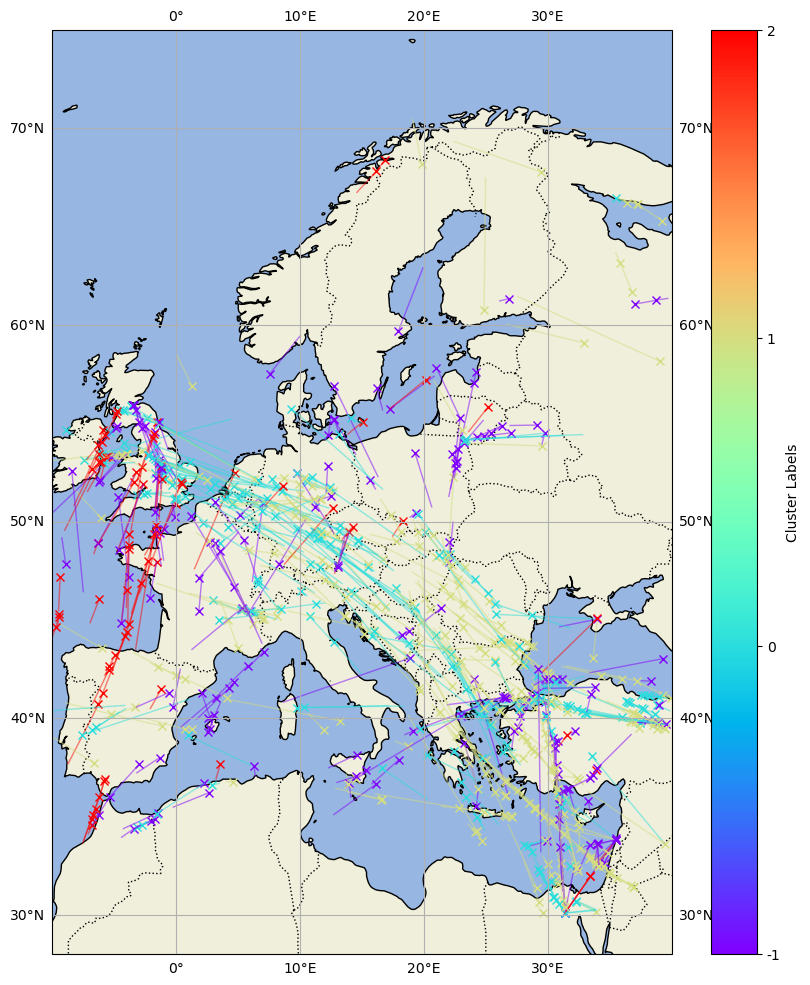

In [55]:
plot_segments_with_labels(seg_from_lat, seg_from_lon, seg_to_lat, seg_to_lon, cluster_labels=cluster_labels, filter=None)

In [53]:
def save_similarity_matrix(similarity_matrix, filename):
    with open(filename, 'wb') as f:
        pickle.dump(similarity_matrix, f)

# Create the directory if it doesn't exist
os.makedirs(PATH_PREFIX + '/data/similarity_mtx', exist_ok=True)
save_similarity_matrix(similarity_matrix, PATH_PREFIX + '/data/similarity_mtx/1716508800.pickle')